1. Data‐Quality Checks

    Missing-value audit: Count nulls in each column.
    
    Value ranges & types: Make sure “Sex” is coded consistently (e.g. “male”/“female”), ages look plausible (no negatives or teens if this isn’t a pediatric study), and heights/weights aren’t swapped or out of realistic bounds.


2. Univariate Exploration

    Summary statistics: Mean, median, standard deviation, min/max for Age, Height, Weight, Duration, Heart_Rate, Body_Temp, and Calories.
    
    Histograms or density plots: See the shape of each distribution—is Weight right-skewed? Is Heart_Rate bimodal (perhaps resting vs active)?
    
    Boxplots: Highlight outliers you might need to cap or investigate.
    

3. Group Comparisons by Sex

    Boxplots or violin plots of Calories by Sex: Do males burn more calories on average?
    
    Descriptive tables: Mean and SD of each numeric feature split by Sex, to uncover systematic differences.


4. Bivariate Relationships

    Correlation matrix / heatmap: Quickly flag strong linear relationships and potential multicollinearity (e.g. Height & Weight).


5. Multivariate Patterns

    Pair-plot (scatter-matrix) for all numeric features: Gives a bird’s-eye view of interactions and non-linear trends.
    
    3D plots or contour plots (if you want): e.g. Duration vs Heart_Rate vs Calories.


6. Outlier & Anomaly Detection

    Z-score or IQR methods: Tag points with extreme Heart_Rate or unrealistic Calories for further review.
    
    Time-series check (if your records are ordered): Look for sudden jumps or plateaus that signal logging errors.



7. Derived‐Feature Ideas

    Heart-Rate Zones: categorize HR into “resting,” “fat-burn,” “cardio,” etc., to see if those bands relate differently to Calories.
    
    BMI = Weight / (Height/100)²: often a better health indicator than raw height or weight.
    
    Age groups: bin into decades if you suspect non-linear age effects.


9. Check for Multicollinearity

    Variance Inflation Factor (VIF): ensure no two predictors are so tightly linked that they confuse your model.

In [1]:
# EDA and FE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Regression model
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Random Forest (tree-based) model
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_log_error, make_scorer
import joblib

# LightGBM
from lightgbm import LGBMRegressor
from sklearn.metrics import make_scorer, mean_squared_error

# 1. Data‐Quality Checks

In [2]:
# # 1. Data‐Quality Checks


# 1.1 Load your training data
df_train = pd.read_csv('train.csv')
df = df_train.copy()    # adjust path if needed

# 1.2 See the schema and non-null counts
df.info()

# 1.3 Count missing values per column
print(df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          750000 non-null  int64  
 1   Sex         750000 non-null  object 
 2   Age         750000 non-null  int64  
 3   Height      750000 non-null  float64
 4   Weight      750000 non-null  float64
 5   Duration    750000 non-null  float64
 6   Heart_Rate  750000 non-null  float64
 7   Body_Temp   750000 non-null  float64
 8   Calories    750000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 51.5+ MB
id            0
Sex           0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
dtype: int64


# 2. Univariate Exploration

                 Age         Height         Weight       Duration  \
count  750000.000000  750000.000000  750000.000000  750000.000000   
mean       41.420404     174.697685      75.145668      15.421015   
std        15.175049      12.824496      13.982704       8.354095   
min        20.000000     126.000000      36.000000       1.000000   
25%        28.000000     164.000000      63.000000       8.000000   
50%        40.000000     174.000000      74.000000      15.000000   
75%        52.000000     185.000000      87.000000      23.000000   
max        79.000000     222.000000     132.000000      30.000000   

          Heart_Rate      Body_Temp       Calories  
count  750000.000000  750000.000000  750000.000000  
mean       95.483995      40.036253      88.282781  
std         9.449845       0.779875      62.395349  
min        67.000000      37.100000       1.000000  
25%        88.000000      39.600000      34.000000  
50%        95.000000      40.300000      77.000000  
75%    

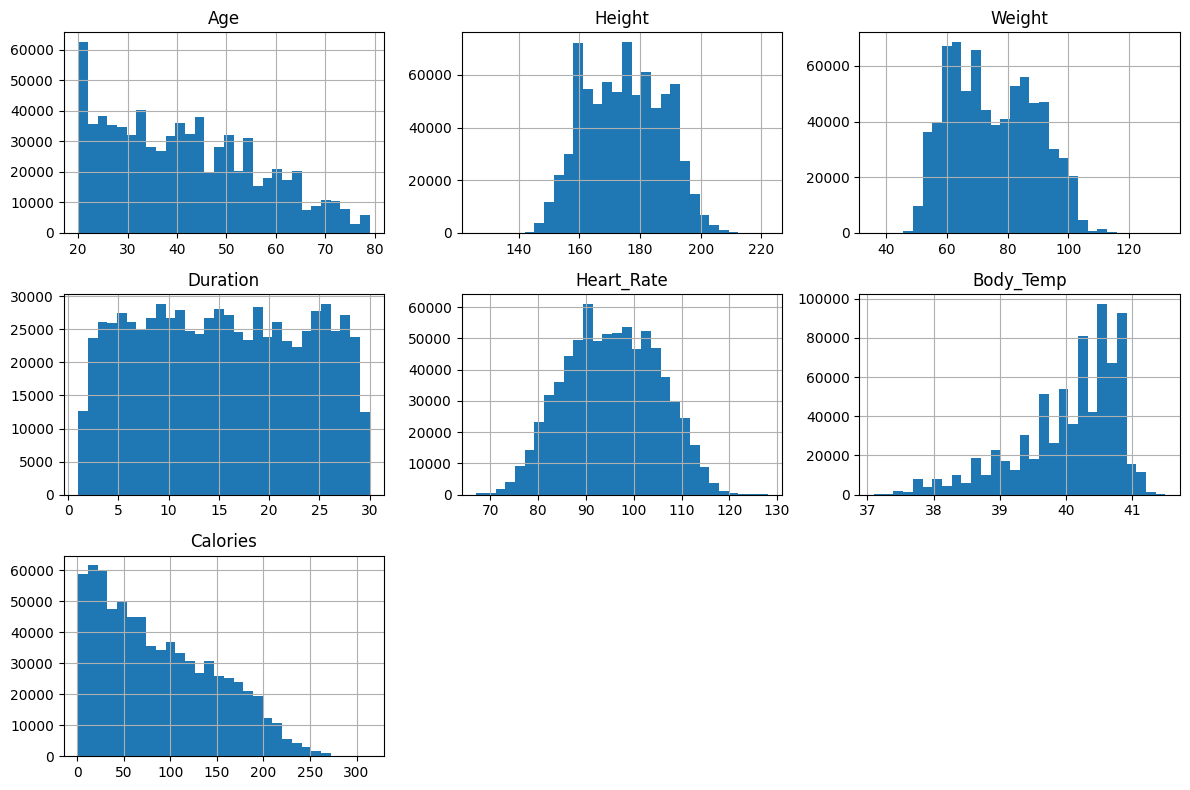

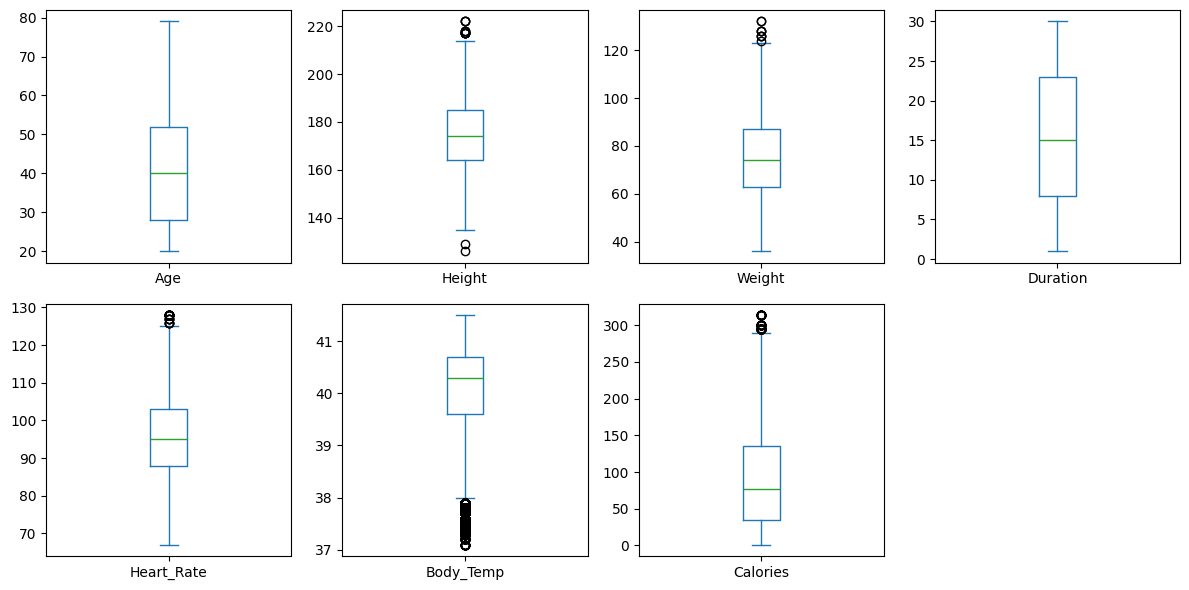

In [3]:
# # 2. Univariate Exploration

# 2.1 Quick summary statistics
print(df[['Age','Height','Weight','Duration','Heart_Rate','Body_Temp','Calories']].describe())

# 2.2 Histograms to see shapes
import matplotlib.pyplot as plt

df[['Age','Height','Weight','Duration','Heart_Rate','Body_Temp','Calories']] \
    .hist(bins=30, figsize=(12,8))
plt.tight_layout()
plt.show()

# 2.3 Boxplots to highlight outliers
df[['Age','Height','Weight','Duration','Heart_Rate','Body_Temp','Calories']] \
    .plot.box(subplots=True, layout=(2,4), figsize=(12,6))
plt.tight_layout()
plt.show()


Univariate Distributions & Outliers

1. Age
Ranges roughly 20–80, with a big spike around the early 20s and then a gradual tail-off.
Boxplot shows few extreme older outliers (>75).

2. Height
Centered around 165 cm (female) and 185 cm (male), but a handful of implausible points below 135 cm or above 215 cm—those may be data errors.

3. Weight
Mostly 50–100 kg, but some values as low as 40 kg and a few over 120 kg.

4. Duration
Uniform-ish spread from 0 to 30 min, with most workouts in the 5–25 min range; no surprising spikes.

5. Heart_Rate
Roughly normal between 70–120 bpm, with a few readings above 125 bpm that stand out as outliers.

6. Body_Temp
Clusters tightly around 39–41 °C. A small cluster below 37.5 °C probably represents non-exercise or sensor misreads.

7. Calories
Right-skewed: lots of low-burn sessions (20–100 kcal) and a long tail up to ~300 kcal with clear high-end outliers.



# 3. Group Comparisons by Sex

              Age                         Height                       Weight  \
             mean        std   count        mean       std   count       mean   
Sex                                                                             
female  41.273650  15.386384  375721  165.022200  8.198525  375721  63.726300   
male    41.567724  14.958469  374279  184.410448  8.589572  374279  86.609032   

                           Duration  ...         Heart_Rate                    \
             std   count       mean  ...   count       mean       std   count   
Sex                                  ...                                        
female  7.011194  375721  15.501013  ...  375721  95.397955  9.406330  375721   
male    8.951300  374279  15.340708  ...  374279  95.570366  9.492556  374279   

        Body_Temp                     Calories                     
             mean       std   count       mean        std   count  
Sex                                                 

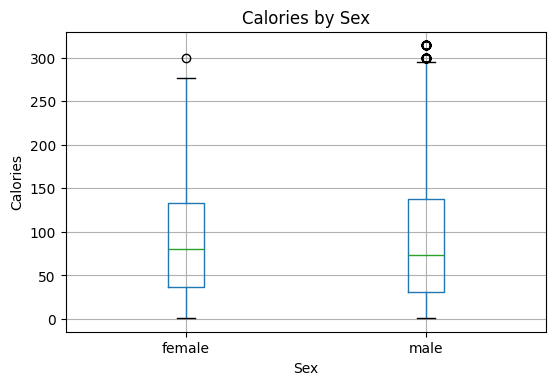

In [4]:
# # 3. Group Comparisons by Sex

# 3.1 Compute mean & std for each numeric feature, grouped by Sex
group_stats = df.groupby('Sex')[['Age','Height','Weight','Duration','Heart_Rate','Body_Temp','Calories']] \
                .agg(['mean','std','count'])
print(group_stats)

# 3.2 Visualize Calories distribution by Sex
df.boxplot(column='Calories', by='Sex', figsize=(6,4))
plt.title('Calories by Sex')
plt.suptitle('')    # remove automatic subtitle
plt.ylabel('Calories')
plt.show()


# 4. Bivariate Relationships

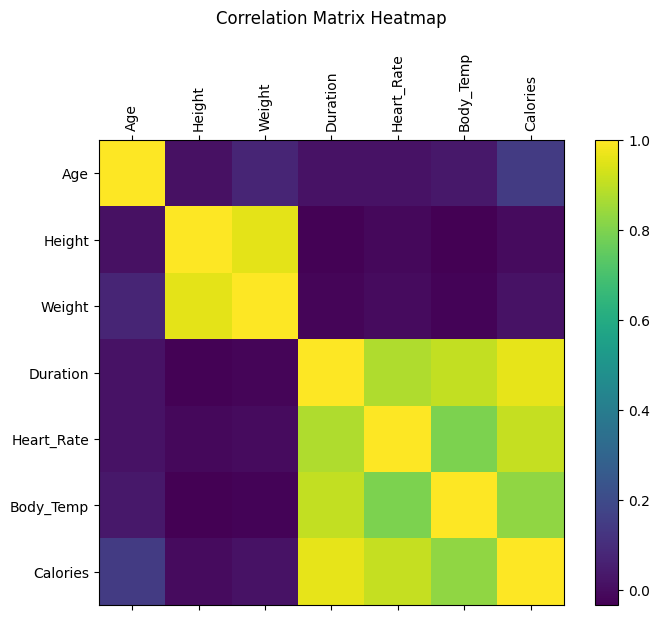

In [5]:
# Pick numeric features
features = ['Age','Height','Weight','Duration','Heart_Rate','Body_Temp','Calories']

# Compute correlation
corr = df[features].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
plt.matshow(corr, fignum=1)
plt.xticks(range(len(features)), features, rotation=90)
plt.yticks(range(len(features)), features)
plt.colorbar()
plt.title('Correlation Matrix Heatmap', pad=20)
plt.show()

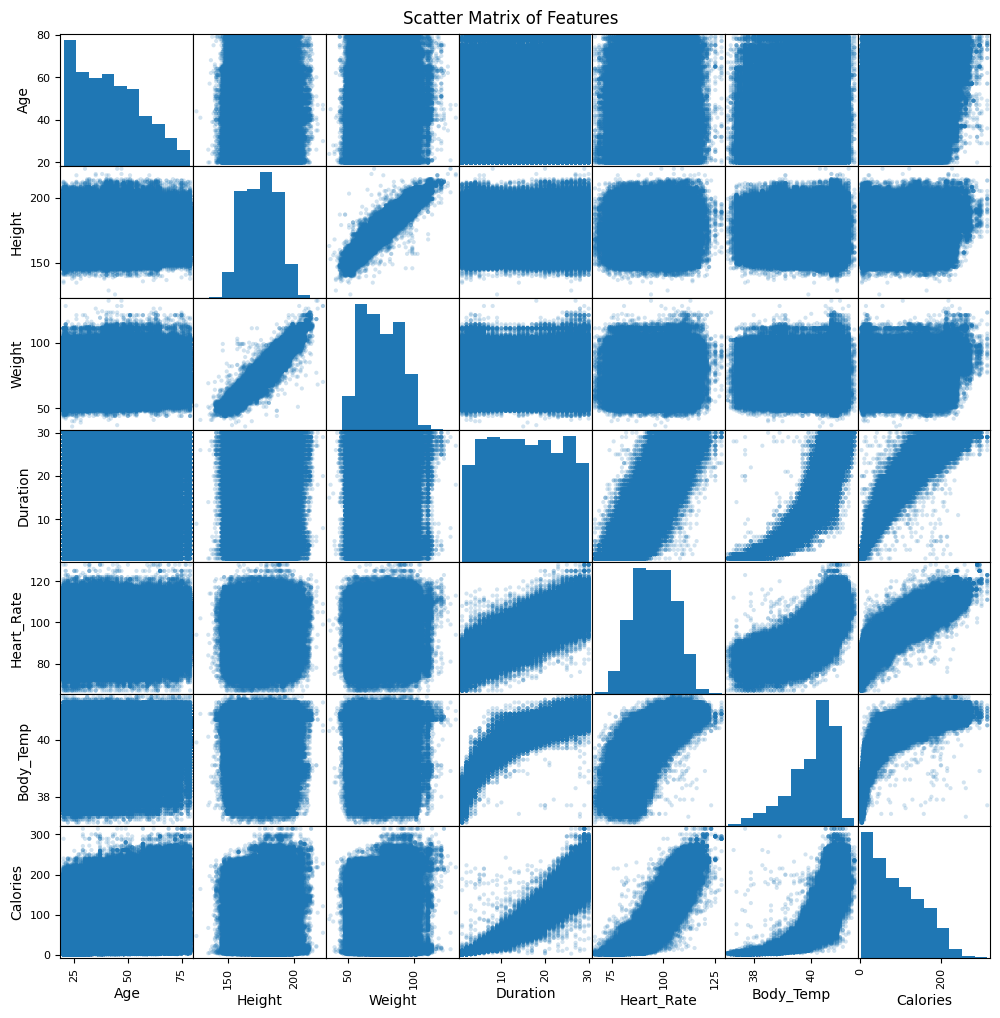

In [6]:
# Draw scatter-matrix
scatter_matrix(df[features], alpha=0.2, diagonal='hist', figsize=(12, 12))
plt.suptitle('Scatter Matrix of Features', y=0.9)
plt.show()

1. Correlation Heatmap
| Pair                       | Corr. coeff. | Interpretation                                                     |
| -------------------------- | -----------: | ------------------------------------------------------------------ |
| **Duration ↔ Calories**    |       \~0.98 | Nearly perfect linear relationship—longer workouts = more burn.    |
| **Heart\_Rate ↔ Calories** |       \~0.82 | Higher average heart rates go hand-in-hand with higher calories.   |
| **Body\_Temp ↔ Calories**  |       \~0.88 | Warmer bodies correlate strongly with burn (a proxy for exertion). |
| **Duration ↔ Heart\_Rate** |       \~0.92 | Longer sessions also tend to have higher heart-rate averages.      |
| **Duration ↔ Body\_Temp**  |       \~0.94 | Same story—longer workouts heat you up more.                       |
| **Weight ↔ Height**        |       \~0.90 | Heavier people are generally taller in this data.                  |
| **Age** with anything      |        <0.20 | Almost no linear effect of age on burn or vitals here.             |

Take-away:

Duration, heart rate, and body temp are all tightly linked (and to Calories).

Height and weight pair off strongly, but they barely move Calories here.

Age doesn’t drive much of the signal.

2. Scatter-Matrix (“Pair-Plot”)
Duration vs Calories: a razor-thin upward band.

Heart_Rate vs Calories: clear positive trend, but a bit more scatter.

Body_Temp vs Calories: also a clean curve upward.

Weight and Height vs Calories: almost a flat cloud—little direct effect.

Age vs Calories: no visible trend at all.

3. Which 3D combinations to plot?
Since Duration, Heart_Rate, and Body_Temp are your top correlates with Calories, the most insightful 3D scatterplots will be:

Duration (x) vs Heart_Rate (y) vs Calories (z)

Duration (x) vs Body_Temp (y) vs Calories (z)

Heart_Rate (x) vs Body_Temp (y) vs Calories (z)

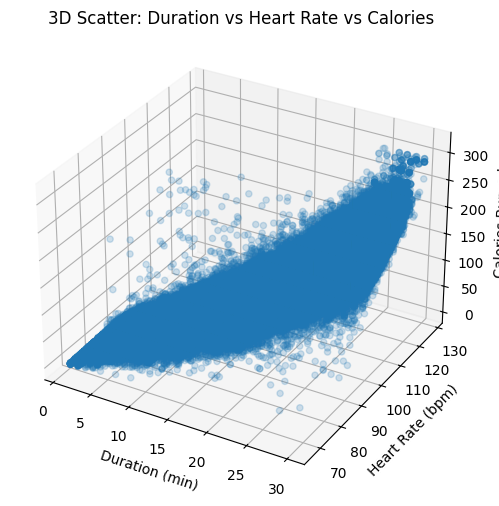

In [7]:
fig = plt.figure(figsize=(8,6))
ax  = fig.add_subplot(111, projection='3d')
ax.scatter(df['Duration'], df['Heart_Rate'], df['Calories'], alpha=0.2)
ax.set_xlabel('Duration (min)')
ax.set_ylabel('Heart Rate (bpm)')
ax.set_zlabel('Calories Burned')
plt.title('3D Scatter: Duration vs Heart Rate vs Calories')
plt.show()

plt.show()

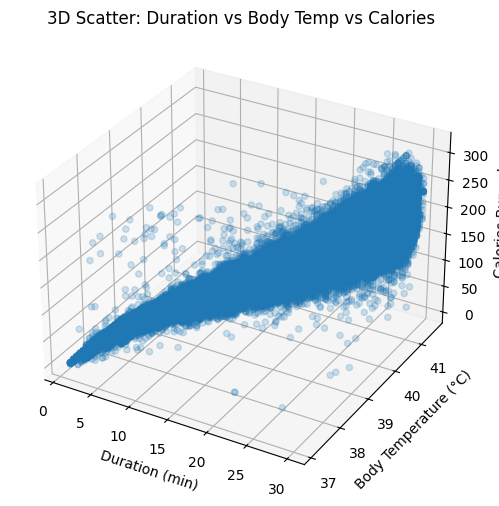

In [8]:
fig = plt.figure(figsize=(8,6))
ax  = fig.add_subplot(111, projection='3d')
ax.scatter(df['Duration'], df['Body_Temp'], df['Calories'], alpha=0.2)
ax.set_xlabel('Duration (min)')
ax.set_ylabel('Body Temperature (°C)')
ax.set_zlabel('Calories Burned')
plt.title('3D Scatter: Duration vs Body Temp vs Calories')
plt.show()


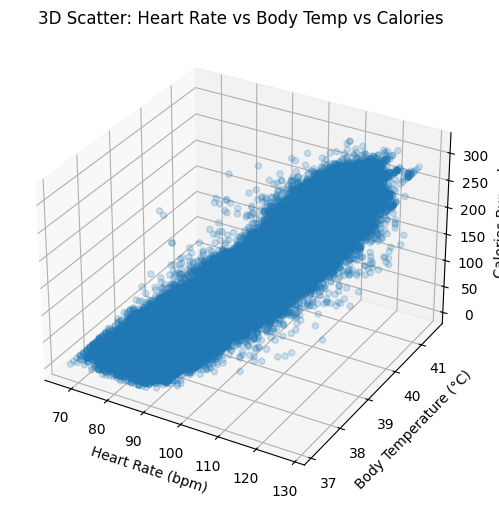

In [9]:
fig = plt.figure(figsize=(8,6))
ax  = fig.add_subplot(111, projection='3d')
ax.scatter(df['Heart_Rate'], df['Body_Temp'], df['Calories'], alpha=0.2)
ax.set_xlabel('Heart Rate (bpm)')
ax.set_ylabel('Body Temperature (°C)')
ax.set_zlabel('Calories Burned')
plt.title('3D Scatter: Heart Rate vs Body Temp vs Calories')
plt.show()


1. Duration (x) vs Heart Rate (y) vs Calories (z)

Rising “shelf”: Calories climb nearly linearly as both Duration and Heart Rate increase.

Low-duration plateau: For workouts under ~5 min, even high heart rates only burn a little—your model will learn that duration is a gating factor.

Spread at long durations: Beyond ~20 min you see more scatter in Calories for the same heart rate—likely because people pacing themselves longer vary more in exertion.

Take-away: Duration × Heart Rate is almost a perfect predictor of burn; a simple interaction term (Duration*HR) could capture most of that signal.

2. Duration (x) vs Body Temp (y) vs Calories (z)

Very similar shape to the HR plot: longer sessions heat you up more, and hotter bodies burn more calories.

Tighter band: Body Temp is less noisy than HR, so the “sheet” is a little thinner—this suggests temp could be an even cleaner proxy for exertion.

Low‐temp floor: Below ~37.5 °C almost no calories are burned, reinforcing that any session where temp never rises is essentially zero‐burn.

Take-away: You might try a feature like (Duration × (Body_Temp – 37)) to encode both length and intensity in one go.

3. Heart Rate (x) vs Body Temp (y) vs Calories (z)

Diagonal ridge: As HR and Temp climb together, Calories go up. Because those two vitals are themselves tightly correlated, the points form a narrow elbow rather than a broad surface.

No “flat” zone at low HR/Temp—calories stay near zero only when both HR and Temp remain low.

Take-away: HR and Temp carry largely the same information. You probably don’t need both as separate predictors; picking the one with fewer outliers (Temp) or combining them (e.g. average normalized z-score) may simplify your model.


Overall Insights & Next Steps


Duration is the master switch—no workout, no burn.

Body temperature edges out heart rate as the cleaner intensity signal.

Almost all the variation in Calories lives in that 3-D “sheet” of (Duration, Intensity) → Burn.

Actionable features to try next:

Interaction: Duration * Body_Temp

Normalized intensity: (Body_Temp - baseline) / Duration

Threshold flags: e.g. Temp > 38 or HR > 100

# 6. Derived‐Feature Ideas

In [10]:
# # 6. Derived‐Feature Ideas

# create the interaction feature
df['dur_temp'] = df['Duration'] * df['Body_Temp']
# correlation with target
print(df['dur_temp'].corr(df['Calories']))


0.9609092775710798


Interpretation: A correlation of 0.96 means this single feature almost linearly tracks Calories.

Why it works: It combines “how long” with “how hot,” so it directly approximates the “area under your exertion curve.”

In [11]:
# 1.1 baseline = 37.0
# df['norm_intensity'] = (df['Body_Temp'] - baseline) / df['Duration'].replace(0, np.nan)
# df['norm_intensity'].fillna(0, inplace=True)   # treat zero-duration as zero intensity
# print(df['norm_intensity'].describe())
# print("Corr with Calories:", df['norm_intensity'].corr(df['Calories']))

# Why it’s negative: By dividing the Δtemp by Duration, longer workouts (even if they burn lots of calories) yield smaller per-minute heat-up rates—and so the ratio actually decreases as Duration grows.

# What to try instead:
# Swap numerator/denominator: Duration / (Body_Temp–37) will correlate positively. Or drop the division entirely and just use ΔTemp (Body_Temp–37) as a standalone feature.


# 1.2 Define a resting‐temp baseline
baseline = 37.0

# 1.3 Compute normalized intensity
#    - Subtract baseline from Body_Temp
#    - Divide by Duration, but avoid dividing by zero
df['norm_intensity'] = (df['Body_Temp'] - baseline) / df['Duration'].replace(0, np.nan)

# 1.4 Replace any NaN (from zero-duration) with 0
df['norm_intensity'] = df['norm_intensity'].fillna(0)

# 1.5 Check the correlation with Calories
corr1 = df['norm_intensity'].corr(df['Calories'])
print("Corr((Body_Temp–37)/Duration, Calories) =", corr1)



# 2.1 Compute the flipped ratio
df['dur_over_delta'] = df['Duration'] / (df['Body_Temp'] - baseline).replace(0, np.nan)

# 2.2 Again, fill any infinities / NaNs (e.g. if Body_Temp==37)
df['dur_over_delta'] = df['dur_over_delta'].replace([np.inf, -np.inf], np.nan).fillna(0)

# 2.3 Check its correlation
corr2 = df['dur_over_delta'].corr(df['Calories'])
print("Corr(Duration/(Body_Temp–37), Calories) =", corr2)




# 3.1 Compute raw temperature rise
df['delta_temp'] = df['Body_Temp'] - baseline

# 3.2 Correlation with Calories
corr3 = df['delta_temp'].corr(df['Calories'])
print("Corr(Body_Temp–37, Calories) =", corr3)



Corr((Body_Temp–37)/Duration, Calories) = -0.7625591464111526
Corr(Duration/(Body_Temp–37), Calories) = 0.9357536661689444
Corr(Body_Temp–37, Calories) = 0.828671222388862


I got three very different “intensity” flavors—and here’s what the numbers tell us:

Feature	Corr with Calories	Notes
(Body_Temp–37)/Duration (per-min heat-up rate)	–0.76	Negative because longer workouts dilute the per-min rise; not a good standalone predictor.
Duration/(Body_Temp–37) (mins per °C)	0.94	Strong positive signal—longer sessions at any given ΔTemp burn more, so this flips the sign.
Body_Temp–37 (total ΔTemp)	0.83	Decent predictor, but it misses the “time” dimension entirely.

Recall I also saw Duration×Body_Temp hit 0.96—that remains your single strongest continuous feature.



temp_high
0     4.661132
1    90.431501
Name: Calories, dtype: float64
hr_high
0     53.461983
1    158.629420
Name: Calories, dtype: float64
Temp ≤ 38 °C  → 4.661131513119378 kcal
Temp >  38 °C → 90.43150062020402 kcal

HR ≤ 100 bpm → 53.46198343153748 kcal
HR >  100 bpm → 158.6294196291941 kcal
temp_high
1    731211
0     18789
Name: count, dtype: int64 

hr_high
0    501676
1    248324
Name: count, dtype: int64 



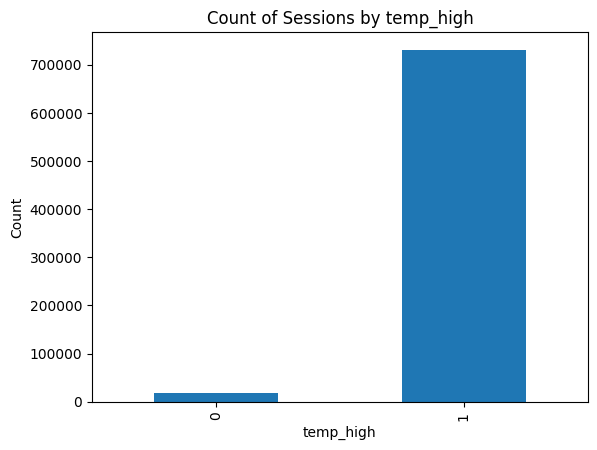

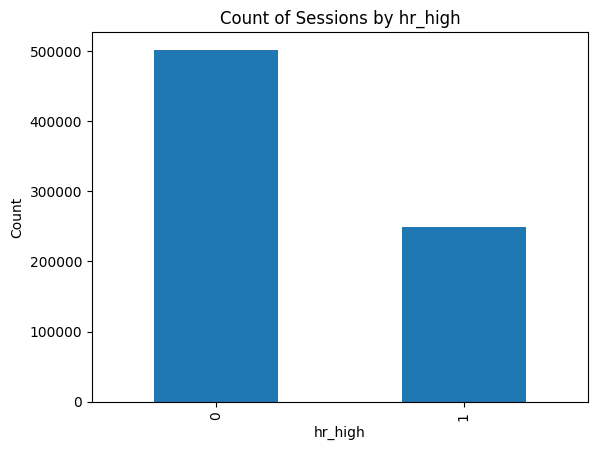

In [12]:
# flag when body temp exceeds 38°C
df['temp_high'] = (df['Body_Temp'] > 38.0).astype(int)

# flag when heart rate exceeds 100 bpm
df['hr_high']   = (df['Heart_Rate'] > 100).astype(int)

# average calories burned when flag is on vs off
print(df.groupby('temp_high')['Calories'].mean())
print(df.groupby('hr_high')['Calories'].mean())

# Average calories burned when temp_high is off vs on
print("Temp ≤ 38 °C  →", df.groupby('temp_high')['Calories'].mean()[0], "kcal")
print("Temp >  38 °C →", df.groupby('temp_high')['Calories'].mean()[1], "kcal\n")

# Average calories burned when hr_high is off vs on
print("HR ≤ 100 bpm →", df.groupby('hr_high')['Calories'].mean()[0], "kcal")
print("HR >  100 bpm →", df.groupby('hr_high')['Calories'].mean()[1], "kcal")


# How many sessions are high vs low?
print(df['temp_high'].value_counts(), "\n")
print(df['hr_high'].value_counts(), "\n")

# A quick bar plot
df['temp_high'].value_counts().sort_index().plot.bar(
    title='Count of Sessions by temp_high', xlabel='temp_high', ylabel='Count')
plt.show()

df['hr_high'].value_counts().sort_index().plot.bar(
    title='Count of Sessions by hr_high', xlabel='hr_high', ylabel='Count')
plt.show()




1. Body­_Temp > 38 °C (temp_high)
Mean Calories

temp_high = 0 (≤ 38 °C): 4.7 kcal

temp_high = 1 (> 38 °C): 90.4 kcal

Count

Only 18 789 sessions never rose above 38 °C (2.5% of data)

731 211 sessions did (97.5% of data)

Take-away: The jump in mean burn is enormous, but almost every workout crosses 38 °C. As a result, temp_high mostly labels “sessions at all” versus “no exercise” (or sensor noise). It’s too imbalanced to give your model much new nuance.

2. Heart_Rate > 100 bpm (hr_high)
Mean Calories

hr_high = 0 (≤ 100 bpm): 53.5 kcal

hr_high = 1 (> 100 bpm): 158.6 kcal

Count

501 676 sessions below or at 100 bpm (~67%)

248 324 sessions above 100 bpm (~33%)

Take-away: This split is much more balanced and still slices out a roughly +105 kcal lift. It’s a solid binary indicator of “light” vs. “moderate+” effort that tree models (or even linear models with a dummy variable) can exploit.

In [13]:
# 1) Extract HR into a 2D array
hr = df['Heart_Rate'].values.reshape(-1,1)

# 2) Fit KMeans with k clusters
k = 4
km = KMeans(n_clusters=k, random_state=42).fit(hr)
labels = km.labels_
centroids = km.cluster_centers_.flatten()

# 3) Order clusters by centroid value so labels go 0=lowest, 3=highest
order = np.argsort(centroids)
new_label = {old: new for new, old in enumerate(order)}
df['hr_zone_km'] = [ new_label[l] for l in labels ]

# 4) Check the cluster centers & burn rates
print("Cluster centers (bpm):", sorted(centroids))
print(df.groupby('hr_zone_km')['Calories'].mean())


Cluster centers (bpm): [np.float64(83.39931170419146), np.float64(92.91941707751977), np.float64(101.81388625897415), np.float64(110.2178522578567)]
hr_zone_km
0     22.849271
1     62.281274
2    126.604260
3    187.474957
Name: Calories, dtype: float64


K-Means has split heart rates into four natural bands with centroids at roughly 83, 93, 102, and 110 bpm, and you can see how mean calorie burn jumps from ~23 kcal up to ~187 kcal across them.

Next steps
1. Add hr_zone_km to feature set

Treat it as a categorical variable (one-hot encode) so model can learn a separate intercept for each zone.



3. Fit a simple model (e.g. a small random forest or linear regression) using your original features plus these zones.

Check cross-validated RMSE vs. the baseline without zones to quantify the lift.


In [14]:
# BMI = Weight / (Height/100)²: often a better health indicator than raw height or weight.

# Age groups: bin into decades if you suspect non-linear age effects.


# 2. Compute BMI
#    BMI = weight (kg) / [height (m)]²
df['BMI'] = df['Weight'] / ( (df['Height'] / 100) ** 2 )

# 3. Bin Age into decades
#    Creates labels “10s”, “20s”, … up to “80s”
age_bins  = list(range(10, 100, 10))           # [10,20,30,…,90]
age_labels = [f'{b}s' for b in age_bins[:-1]]  # ['10s','20s',…,'80s']
df['age_decade'] = pd.cut(
    df['Age'],
    bins=age_bins,
    right=False,
    labels=age_labels
)

# 4. Quick checks
print("BMI ↔ Calories corr:", df['BMI'].corr(df['Calories']))
print("\nMean Calories by age_decade:")
print(df.groupby('age_decade')['Calories'].mean())

BMI ↔ Calories corr: 0.049225725380128704

Mean Calories by age_decade:
age_decade
10s           NaN
20s     78.464903
30s     85.338498
40s     87.796954
50s     92.481789
60s    104.014548
70s    112.213509
80s           NaN
Name: Calories, dtype: float64


/tmp/ipykernel_19/3362219595.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby('age_decade')['Calories'].mean())


BMI has almost no linear relationship with Calories (corr ≈ 0.05). In this workout dataset, weight-for-height by itself isn’t a strong burn predictor—likely because exercise intensity and duration overwhelm body‐shape effects.


Age by decade shows a clear upward trend:

People in their 20s burn ~78 kcal on average,

in their 30s ~85 kcal,

…

up to those in their 70s burning ~112 kcal.
The missing “10s” and “80s” simply mean you don’t have any participants in those brackets.

In [15]:
# pick your feature and reshape
X = df['Age'].values.reshape(-1,1)

# fit k clusters
k = 5
km = KMeans(n_clusters=k, random_state=42).fit(X)

# get the raw labels and centroids
labels    = km.labels_
centroids = km.cluster_centers_.flatten()

# order them so bin 0 is the lowest centroid, etc.
order_map = {old: new for new, old in enumerate(np.argsort(centroids))}
df['age_km_bin'] = [order_map[l] for l in labels]

# see what ranges each cluster covers
ranges = df.groupby('age_km_bin')['Age'].agg(['min','max','count'])
print("Cluster centers:", sorted(centroids))
print(ranges)


Cluster centers: [np.float64(23.038290330076563), np.float64(31.780417770407723), np.float64(41.78128657695062), np.float64(53.77974999397125), np.float64(68.40952805761454)]
            min  max   count
age_km_bin                  
0            20   27  172080
1            28   36  148359
2            37   47  171727
3            48   61  165916
4            62   79   91918


Key Engineered Features & Their Signals

| Feature              | How It’s Defined                                                           | Corr / Impact                                   | Notes                                                                              |
| -------------------- | -------------------------------------------------------------------------- | ----------------------------------------------- | ---------------------------------------------------------------------------------- |
| **`dur_temp`**       | `Duration × Body_Temp`                                                     | **0.9609**                                      | Top continuous predictor—captures “duration × intensity.”                          |
| **`dur_over_delta`** | `Duration / (Body_Temp – 37)`                                              | **0.9358**                                      | Flipped rate (“minutes per °C rise”) gives a very strong positive signal.          |
| **`delta_temp`**     | `Body_Temp – 37`                                                           | **0.8287**                                      | Total temperature rise—good, but misses workout length.                            |
| **`temp_high`**      | `Body_Temp > 38°C` (binary)                                                | +85 kcal lift vs. low—but **97.5%** of workouts | Too imbalanced (almost every session crosses 38°C), so offers little extra nuance. |
| **`hr_high`**        | `Heart_Rate > 100 bpm` (binary)                                            | +105 kcal lift vs. low; **33%** of workouts     | A balanced, clear “light vs. moderate+” exertion flag—useful for tree splits.      |
| **`hr_zone_km`**     | 4 clusters from K-Means on Heart\_Rate (centroids \~83, 93, 102, 110)      | Mean Calories ≈ \[23, 62, 127, 187] per zone    | Data‐driven HR bands; one-hot encode for highest lift.                             |
| **`BMI`**            | `Weight / (Height/100)²`                                                   | **0.05**                                        | Negligible correlation here—can be dropped or kept for non-linear models.          |
| **`age_decade`**     | Age binned into decades (“20s”, “30s”, …)                                  | Mean Calories ↑ with age: 78 → 112 kcal         | Captures non-linear age effect; one-hot encode for separate intercepts.            |
| **`age_km_bin`**     | 5 clusters from K-Means on Age (ranges: 20–27, 28–36, 37–47, 48–61, 62–79) | —                                               | Automatically discovered age brackets; can substitute or supplement `age_decade`.  |


# 7. Check for Multicollinearity

In [16]:
## 7. Check for Multicollinearity
# 1) Build your feature matrix as before
X = pd.concat([
    df[['dur_temp','dur_over_delta','delta_temp','BMI']],
    pd.get_dummies(df['hr_zone_km'], prefix='hr',    drop_first=True),
    pd.get_dummies(df['age_km_bin'], prefix='age',   drop_first=True),
], axis=1)

# 2) Ensure everything is numeric and finite
X = X.replace([np.inf, -np.inf], np.nan).fillna(0)
X = X.astype(float)   # <-- force every column to float

# 3) (Optional) add constant
X['const'] = 1.0

# 4) Compute VIFs
vif_data = pd.DataFrame({
    'feature': X.columns,
    'VIF':     [variance_inflation_factor(X.values, i)
                for i in range(X.shape[1])]
})

print(vif_data.sort_values('VIF').reset_index(drop=True))

           feature         VIF
0              BMI    1.041673
1            age_4    1.388656
2            age_1    1.502239
3            age_2    1.565269
4            age_3    1.575941
5             hr_1    2.290559
6             hr_3    3.930827
7             hr_2    4.001480
8       delta_temp    7.955198
9   dur_over_delta   31.355900
10        dur_temp   53.859463
11           const  344.245420


The VIF table tells us:

Constant (const) is huge—that’s expected and can be ignored.

Very low collinearity for BMI and age‐decade dummies (VIF ≲ 1.6).

Moderate collinearity among HR‐zone dummies (VIF ≲ 4).

Delta_temp is borderline (VIF ≈ 8), but still under the “10” threshold.

High collinearity for:

dur_over_delta (VIF ≈ 31)

dur_temp (VIF ≈ 54)

These two both involve Duration and Body_Temp, so it makes sense they’re nearly linear combinations of each other and driving each other’s VIF up.



# 8. Random Forest Regressor

In [6]:
# 1.copy data
df_RF  = df_train.copy()

# 2. Re-create the k-means bins from  EDA

# 2.1 Heart-Rate zones (4 clusters)
hr_km = KMeans(n_clusters=4, random_state=42).fit(df_RF[['Heart_Rate']])
df_RF['hr_zone_km'] = hr_km.predict(df_RF[['Heart_Rate']])
# reorder labels so that 0 < 1 < 2 < 3 in terms of centroid value
hr_centroids = hr_km.cluster_centers_.flatten()
hr_order     = np.argsort(hr_centroids)
hr_map       = {old: new for new, old in enumerate(hr_order)}
df_RF['hr_zone_km'] = df_RF['hr_zone_km'].map(hr_map)

# 2.2 Age bins (5 clusters)
age_km = KMeans(n_clusters=5, random_state=42).fit(df_RF[['Age']])
df_RF['age_km_bin'] = age_km.predict(df_RF[['Age']])
age_centroids = age_km.cluster_centers_.flatten()
age_order     = np.argsort(age_centroids)
age_map       = {old: new for new, old in enumerate(age_order)}
df_RF['age_km_bin'] = df_RF['age_km_bin'].map(age_map)

# 3. Recompute continuous FE
df_RF['dur_temp']       = df_RF['Duration'] * df_RF['Body_Temp']
df_RF['delta_temp']     = df_RF['Body_Temp'] - 37
df_RF['dur_over_delta'] = df_RF['Duration'] / df_RF['delta_temp'].replace(0, np.nan)

# 4. Select features & target
X = df_RF[['dur_temp','dur_over_delta','delta_temp','hr_zone_km','age_km_bin']]
y = df_RF['Calories']

# 5. Build pipeline
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first', sparse_output=False), ['hr_zone_km','age_km_bin']),
], remainder='passthrough')

rmsle_scorer = make_scorer(
    lambda y_true, y_pred: np.sqrt(mean_squared_log_error(y_true, y_pred)),
    greater_is_better=False
)

rf_pipeline = Pipeline([
    ('prep', preprocessor),
    ('rf', RandomForestRegressor(
        n_estimators=200,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    )),
])

# 6. CV with RMSLE
scores = cross_val_score(
    rf_pipeline, X, y,
    cv=5,
    scoring=rmsle_scorer,
    error_score='raise'
)
print(f"RF RMSLE: {(-scores.mean()):.4f} ± {scores.std():.4f}")

# 7. Fit & save
rf_pipeline.fit(X, y)
joblib.dump(rf_pipeline, 'rf_calorie_pipeline.pkl')

RF RMSLE: 0.1241 ± 0.0008


['rf_calorie_pipeline.pkl']

# Submission part

In [8]:
# # 1. Load trained pipeline
# rf_pipeline = joblib.load('rf_calorie_pipeline.pkl')

# # 2. Reload training data to refit your K-Means bins
# df_train = pd.read_csv('train.csv')

# # Heart-rate K-Means (4 clusters)
# hr_km = KMeans(n_clusters=4, random_state=42)
# hr_km.fit(df_train[['Heart_Rate']])
# hr_centroids = hr_km.cluster_centers_.flatten()
# hr_order     = np.argsort(hr_centroids)
# hr_map       = {old: new for new, old in enumerate(hr_order)}

# # Age K-Means (5 clusters)
# age_km = KMeans(n_clusters=5, random_state=42)
# age_km.fit(df_train[['Age']])
# age_centroids = age_km.cluster_centers_.flatten()
# age_order     = np.argsort(age_centroids)
# age_map       = {old: new for new, old in enumerate(age_order)}

# # 3. Load & FE the test set
# df_test = pd.read_csv('test.csv')
# df_test['dur_temp']       = df_test['Duration'] * df_test['Body_Temp']
# df_test['delta_temp']     = df_test['Body_Temp'] - 37
# df_test['dur_over_delta'] = df_test['Duration'] / df_test['delta_temp'].replace(0, np.nan)

# # 3a. Assign clusters
# df_test['hr_zone_km'] = hr_km.predict(df_test[['Heart_Rate']])
# df_test['hr_zone_km'] = df_test['hr_zone_km'].map(hr_map)

# df_test['age_km_bin'] = age_km.predict(df_test[['Age']])
# df_test['age_km_bin'] = df_test['age_km_bin'].map(age_map)

# # 4. Select the same feature columns
# X_test = df_test[['dur_temp','dur_over_delta','delta_temp','hr_zone_km','age_km_bin']]

# # 5. Predict
# preds = rf_pipeline.predict(X_test)

# # 6. Build & save submission
# submission = pd.read_csv('sample_submission.csv')
# submission['Calories'] = preds
# submission.to_csv('submission.csv', index=False)

# print("Wrote submission.csv — ready to submit!")